# Load the DataSet
The Dataset is a set of 50,000 of highly polarized review from the Internet Movie Databse. They're split into 25k reviews for training and 25k for testing. Each set containing 50% positive and 50% negative reviews.

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras import models, layers, losses, metrics, optimizers

num_words means will will keep only the top 10k most frequently ocuring words. Rare words will be discarded. This allows the size of the data set to me manageable.

The variables train_data and test_data are lists of reviews. Each review in the list is a list of word indicies. train_labels and test_labels are lists of 0s and 1s where 0 means negative and 1 means positive.

In [59]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

In [60]:
print ('A slice of the first review:', train_data[0][0:8], '\n',
       'A Label for the frist review:', train_labels[0])

A slice of the first review: [1, 14, 22, 16, 43, 530, 973, 1622] 
 A Label for the frist review: 1


In [61]:
# Check to se that the number of words we have does not exceed 10k
max([max(sequence) for sequence in train_data])

9999

In [62]:
# Decode from reviews to english
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

# Preparing the data
Two ways of turning data, the lists, into tensors
* Pad the lists to that they all have the same length, then turn them into an integer tensor of shape (samples, word_indicies)
    * use this a the first layer in the network
* One-hot encode the lists to turn them into vectors of -s and 1s.
    * The sequence $\left[ 3, 5 \right]$ will be a 10k dimensional nector that will be 0s except for indicies 3 and 5 which will be filled with 1s.

    * can use this as the first layer
    
We will one hot encode the data

In [63]:
def vectorize_sequences(sequences, dimension = 10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

In [77]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [78]:
# This is what one of the samples look like
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [79]:
y_train = np.asarray((train_labels).astype('float32'))
y_test = np.asarray((test_labels).astype('float32'))

# Building the network
Inputs: Vectors
Labels: Scalars (0s and 1s)

This type of network will do well is a simple stack of fully connected (Dense) layers with relu activations. There will be 16 hidden units in the layer which is a dimension in the representation space of the layer. A dense layer with a relu activation implements the following chain of tensor operations
$$
\text{output} = \text{relu}\left(  \text{dot}\left(  W, \text{input} \right) + b\right)
$$

Activation functions all

16 hidden units means the weight matrix $W$ will have the shape: (input dimension, 16). The dot product with $W$ will project the input data onto a 16-dimensional representation space. Having more hidden units allows the network to learn more-complex representation, but it will make the network more computationally expensive and may lead to learning unwanted patters (patterns that will improve the performance on the training data but not on the test data).

Things to consider when using Dense layers:
    * How many layers to use
    * How many hidden units to use for each layer
 

In [80]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

## Choose a loss function and optimizer
Because we're working with binary classifcation (positive, negative) and the output of the network is a probability it's best to use `binary_crossentropy` loss. `mean_squared_error` can also be used. However, `crossentropy` us a quantity from Information Theory that measures the distance between probability distributions, between the ground truth distribution and the predictions.

We configure the model with the `rmsprop` optimizer and `binary_crossentropy` loss function.

In [81]:
# model.compile(optimizer = optimizers.RMSprop(lr=0.001),
#              loss = losses.binary_crossentropy,
#              metrics = [metrics.binary_accuracy])
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [82]:
# Prepare the validation data
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

# Train the network
This will take less than 2 seconds per epoch. Ther ewill be a slight pause at the end of every epoch as the model omputes loss and accuracy on the 10,000 samples of the validation data.

The histroy object is a dictionary containing data on everything that happened during the training. The dictionary has four entries: one per metric during the training and validation.

In [83]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs = 20,
                   batch_size = 512,
                   validation_data = (x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 123us/step - loss: 0.5150 - acc: 0.7897 - val_loss: 0.3957 - val_acc: 0.8631
Epoch 2/20
15000/15000 [==============================] - 1s 75us/step - loss: 0.3130 - acc: 0.8994 - val_loss: 0.3197 - val_acc: 0.8771
Epoch 3/20
15000/15000 [==============================] - 1s 73us/step - loss: 0.2286 - acc: 0.9269 - val_loss: 0.2912 - val_acc: 0.8849
Epoch 4/20
15000/15000 [==============================] - 1s 72us/step - loss: 0.1834 - acc: 0.9393 - val_loss: 0.2723 - val_acc: 0.8899
Epoch 5/20
15000/15000 [==============================] - 1s 80us/step - loss: 0.1486 - acc: 0.9517 - val_loss: 0.2835 - val_acc: 0.8863
Epoch 6/20
15000/15000 [==============================] - 1s 86us/step - loss: 0.1229 - acc: 0.9611 - val_loss: 0.2881 - val_acc: 0.8863
Epoch 7/20
15000/15000 [==============================] - 1s 84us/step - loss: 0.1036 - acc: 0.9698 - val_loss: 0.3045 - val_ac

# Plot the training and validation loss
It can be seen that train loss decreases with every epoch and the training accuracy increases with every epoch. This is expect when running gradient descent optimization-the quantity being minimized should be less with every optimization. This is not the case for validation loss and accuracy: the peak to some point. This is an example of overfitting, when the model performs better on the training data doens't nevessarily model on novel data.

In [84]:
# Print the keys of the dictionary
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [85]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, 20 + 1)

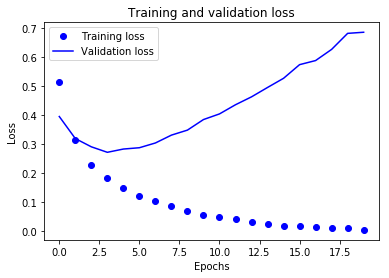

In [86]:
plt.plot(loss_values, 'bo', label='Training loss')
plt.plot(val_loss_values, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

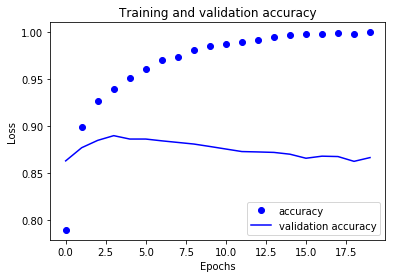

In [87]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(acc_values, 'bo', label='accuracy')
plt.plot(val_acc_values, 'b', label='validation accuracy')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Retrain a new model to prevent overfitting

In [88]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 2s 61us/step - loss: 0.4687 - acc: 0.8208
Epoch 2/4
25000/25000 [==============================] - 1s 57us/step - loss: 0.2663 - acc: 0.9080
Epoch 3/4
25000/25000 [==============================] - 1s 57us/step - loss: 0.2028 - acc: 0.9282
Epoch 4/4
25000/25000 [==============================] - 2s 81us/step


## The new model achieves an accuracy of 88%

In [89]:
results

[0.29121099311828613, 0.88524]

# Use the trained netwrok to generate predictions on new data
The model is confident on some samples, and not on other where the score is .4, .6 ish


In [94]:
model.predict(x_test)

array([[0.17670843],
       [0.99996305],
       [0.8742501 ],
       ...,
       [0.09365413],
       [0.06663922],
       [0.53076005]], dtype=float32)